In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import os
from dotenv import load_dotenv
from collections import defaultdict
import sys


In [3]:
load_dotenv()
api_key = os.getenv("ETHERSCAN_API_KEY")

True

In [4]:
# Example addresses
addresses = [
    "0x7568160091792b16066A06a115704b059814e9cc",
    "0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8",
    "0xfd78EE919681417d192449715b2594ab58f5D002",
    "0xAbb07822F471773Ff00b9444308ceEB7cf0dACa7",
    "0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9"
]

In [5]:
# Known mixer/bridge contract addresses
known_services = {
    'TornadoCash': [
        '0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc',
        '0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936',
        '0x5efda50f22d34F262c29268506C5Fa42cB56A1Ce',
        '0x0836222F2B2B24A3F36f98668Ed8F0B38D1a872f',
        '0x169AD27A470D064DEDE56a2D3ff727986b15D52B',
    ],
    'Tokenlon': ['0x4a14347083b80e5216ca31350a2d21702ac3650d'],
    'UniswapV2': ['0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D'],
    '1inch': ['0x1111111254fb6c44bac0bed2854e76f90643097d'],
}

In [6]:
# Transaction fetching functions
def fetch_erc20_transactions(address):
    url = f"https://api.etherscan.io/api"
    params = {
        'module': 'account',
        'action': 'tokentx',
        'address': address,
        'startblock': 0,
        'endblock': 99999999,
        'sort': 'asc',
        'apikey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] == '1':
        df = pd.DataFrame(data['result'])
        df['token_value'] = df['value'].astype(float) / (10 ** df['tokenDecimal'].astype(int))
        df['time'] = pd.to_datetime(df['timeStamp'].astype(int), unit='s', utc=True)
        return df
    return pd.DataFrame()


In [7]:
def fetch_normal_transactions(address):
    url = f"https://api.etherscan.io/api"
    params = {
        'module': 'account',
        'action': 'txlist',
        'address': address,
        'startblock': 0,
        'endblock': 99999999,
        'sort': 'asc',
        'apikey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] == '1':
        df = pd.DataFrame(data['result'])
        df['value_eth'] = df['value'].astype(float) / 1e18
        df['time'] = pd.to_datetime(df['timeStamp'].astype(int), unit='s', utc=True)
        return df
    return pd.DataFrame()

In [ ]:
def analyze_address(address):
    print(f"\n{'='*50}")
    print(f"Analyzing address: {address}")
    print(f"{'='*50}\n")
    sys.stdout.flush()

    # Fetch transactions
    erc20 = fetch_erc20_transactions(address)
    normal = fetch_normal_transactions(address)

    if erc20.empty and normal.empty:
        print(f"No transactions found for {address}.")
        sys.stdout.flush()
        return []  # no plots to return

    # Defensive: only add lowercase columns if DataFrame not empty
    if not erc20.empty:
        erc20['to_lower'] = erc20['to'].str.lower()
        erc20['from_lower'] = erc20['from'].str.lower()
    else:
        erc20['to_lower'] = pd.Series(dtype=str)
        erc20['from_lower'] = pd.Series(dtype=str)

    if not normal.empty:
        normal['to_lower'] = normal['to'].str.lower()
        normal['from_lower'] = normal['from'].str.lower()
    else:
        normal['to_lower'] = pd.Series(dtype=str)
        normal['from_lower'] = pd.Series(dtype=str)

    plots_to_show = []

    for name, contract_list in known_services.items():
        addr_set = [a.lower() for a in contract_list]

        erc20_hits = erc20[erc20['to_lower'].isin(addr_set) | erc20['from_lower'].isin(addr_set)] if not erc20.empty else pd.DataFrame()
        erc20_count = len(erc20_hits)
        erc20_volume = erc20_hits['token_value'].sum() if not erc20_hits.empty else 0.0

        normal_hits = normal[normal['to_lower'].isin(addr_set) | normal['from_lower'].isin(addr_set)] if not normal.empty else pd.DataFrame()
        normal_count = len(normal_hits)
        normal_volume = normal_hits['value_eth'].sum() if not normal_hits.empty else 0.0

        print(f"{name}:")
        print(f"  ERC-20 txs: {erc20_count} | Token volume: {erc20_volume:.2f}")
        print(f"  ETH txs  : {normal_count} | ETH volume: {normal_volume:.4f}")
        sys.stdout.flush()

        if erc20_count > 0:
            plots_to_show.append(('ERC-20', name, address, erc20_hits.copy()))
        if normal_count > 0:
            plots_to_show.append(('ETH', name, address, normal_hits.copy()))

    print(f"\nCompleted analysis for {address}\n")
    sys.stdout.flush()
    return plots_to_show




Total addresses to analyze: 5

>>> Starting analysis for 0x7568160091792b16066A06a115704b059814e9cc


Analyzing address: 0x7568160091792b16066A06a115704b059814e9cc

TornadoCash:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 0 | ETH volume: 0.0000
Tokenlon:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 0 | ETH volume: 0.0000
UniswapV2:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 11 | ETH volume: 0.7487
1inch:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 0 | ETH volume: 0.0000

Completed analysis for 0x7568160091792b16066A06a115704b059814e9cc

Returned 1 plots for 0x7568160091792b16066A06a115704b059814e9cc

<<< Finished analysis for 0x7568160091792b16066A06a115704b059814e9cc

>>> Starting analysis for 0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8


Analyzing address: 0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8

TornadoCash:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 0 | ETH volume: 0.0000
Tokenlon:
  ERC-20 txs: 0 | Token volume: 0.00
  ETH txs  : 0 | ETH volume: 0.

<Axes: title={'center': '0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8 - UniswapV2 ETH txs'}, xlabel='time'>

Text(0, 0.5, 'ETH Tx Count')

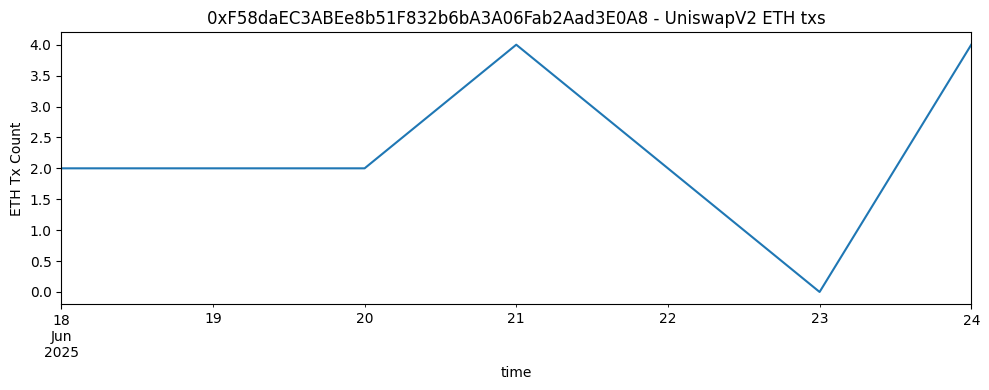


Charts for address: 0xAbb07822F471773Ff00b9444308ceEB7cf0dACa7


<Axes: title={'center': '0xAbb07822F471773Ff00b9444308ceEB7cf0dACa7 - Tokenlon ERC-20 txs'}, xlabel='time'>

Text(0, 0.5, 'ERC-20 Tx Count')

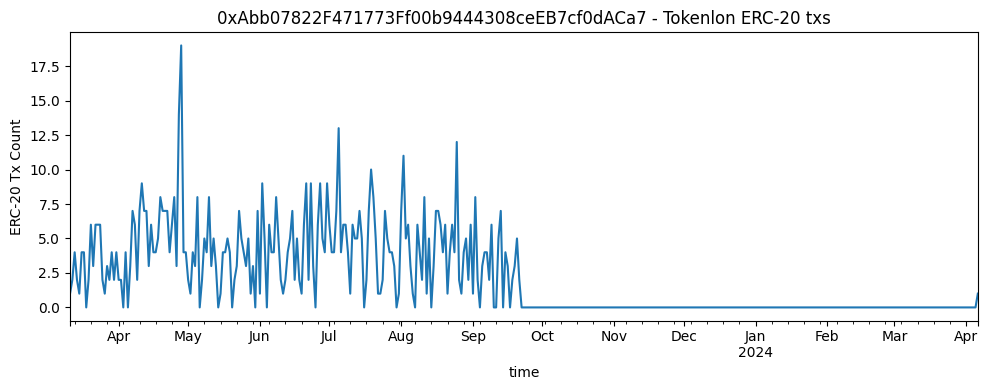


Charts for address: 0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9


<Axes: title={'center': '0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9 - TornadoCash ERC-20 txs'}, xlabel='time'>

Text(0, 0.5, 'ERC-20 Tx Count')

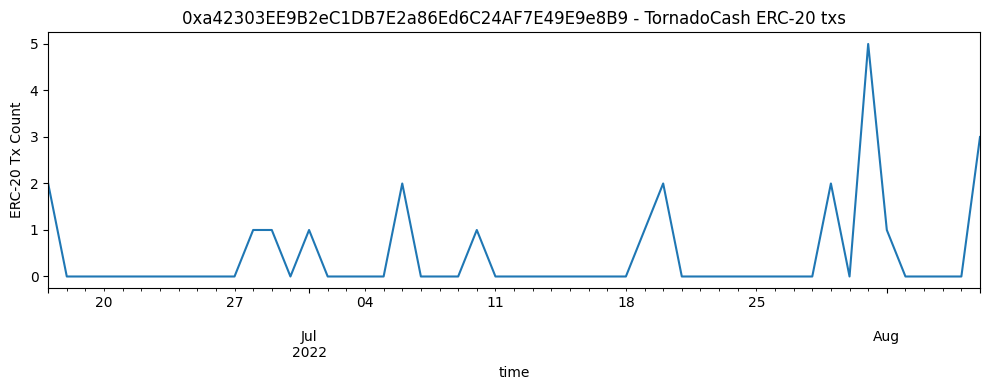

<Axes: title={'center': '0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9 - TornadoCash ETH txs'}, xlabel='time'>

Text(0, 0.5, 'ETH Tx Count')

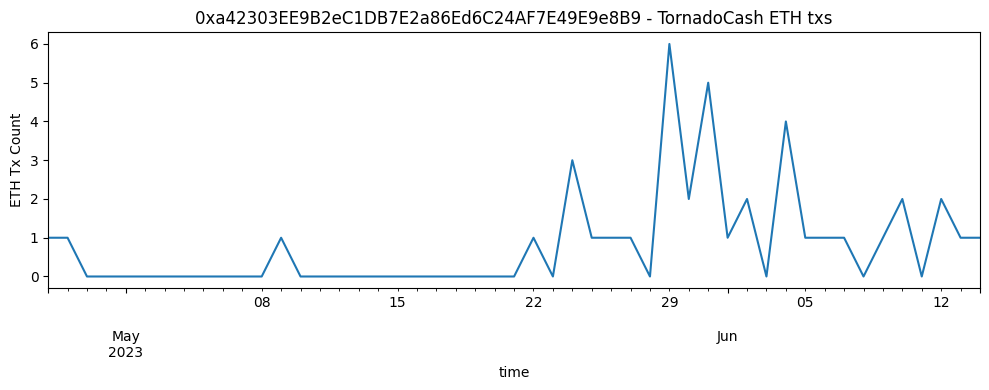


=== All analyses and charts completed ===


In [ ]:
# === MAIN EXECUTION ===

all_plots = []

print(f"Total addresses to analyse: {len(addresses)}\n")
sys.stdout.flush()

for addr in addresses:
    print(f">>> Starting analysis for {addr}\n")
    sys.stdout.flush()

    try:
        plots = analyze_address(addr)
        print(f"Returned {len(plots)} plots for {addr}\n")
        sys.stdout.flush()
        all_plots.extend(plots)
    except Exception as e:
        print(f"❌ Error during analysis of {addr}: {e}\n")
        sys.stdout.flush()

    print(f"<<< Finished analysis for {addr}\n")
    sys.stdout.flush()

# Group plots by address
charts_by_address = defaultdict(list)
for tx_type, name, addr, df in all_plots:
    charts_by_address[addr].append((tx_type, name, df))

# Plotting
for addr, charts in charts_by_address.items():
    print(f"\nCharts for address: {addr}")
    sys.stdout.flush()
    for tx_type, service, df in charts:
        resampled = df.set_index('time').resample('D').size()

        if len(resampled) < 2:
            print(f"⚠️  Skipping plot for {addr} - {service} ({tx_type}), not enough data.")
            sys.stdout.flush()
            continue

        fig, ax = plt.subplots(figsize=(10, 4))
        resampled.plot(ax=ax, title=f"{addr} - {service} {tx_type} txs")
        ax.set_ylabel(f"{tx_type} Tx Count")
        fig.tight_layout()
        plt.show()

print("\n=== All analyses and charts completed ===")


